## Рекомендация еды к вину и наоборот на основе онтологий

В этом примере мы попробуем извлечь знания из готовой RDF+OWL онтологии, доставшейся нам в наследство от Semantic Web. В дальнейшем на основе этого можно будет построить агента, который сможет подбирать вино к еде и наоборот на основе формализованных знаний.

Для начала, установим необходимые библиотеки:

In [11]:
%pip install -q owlready2 rdflib pytholog git+https://github.com/RDFLib/OWL-RL.git@933abdbc9a13cb49230d238d3b148334b0c0b2b0


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


Работать с RDF-онтологиями можно разными путями:
* Библиотека owlready 2 строит по онтологии дерево Python-классов и позволяет работать на уровне классов объектов
* Библиотека rdflib более низкоуровневая, позволяет работать с RDF-графами на уровне троек объект-атрибут-значение

Обе библиотеки поддерживают в каком-то виде логический вывод в декскриптивных логиках. Однако для логического вывода можно использовать и другие инструменты, например, какую-то реализацию языка Prolog.

## Используем OwlReady 2

Для начала, загрузим онтологии еды и вина:

In [2]:
from owlready2 import *
food = get_ontology("../source/food.owl").load()
wine = get_ontology("../source/wine.owl").load()

Посмотрим, какие существуют классы в онтологии еды:

In [3]:
list(food.classes())

[food.Meal,
 food.MealCourse,
 food.PotableLiquid,
 food.EdibleThing,
 food.ConsumableThing,
 food.Fruit,
 food.BlandFish,
 food.Fish,
 food.NonBlandFish,
 food.BlandFishCourse,
 food.CheeseNutsDessert,
 food.Dessert,
 food.SweetDessert,
 food.CheeseNutsDessertCourse,
 food.DarkMeatFowl,
 food.Fowl,
 food.LightMeatFowl,
 food.DarkMeatFowlCourse,
 food.Meat,
 food.OtherTomatoBasedFood,
 food.Pasta,
 food.Seafood,
 food.DessertCourse,
 food.EatingGrape,
 food.Grape,
 food.Shellfish,
 food.FishCourse,
 food.NonSweetFruit,
 food.SweetFruit,
 food.FruitCourse,
 food.Juice,
 food.LightMeatFowlCourse,
 food.Wine,
 food.NonBlandFishCourse,
 food.NonConsumableThing,
 food.NonOysterShellfish,
 food.OysterShellfish,
 food.NonOysterShellfishCourse,
 food.NonRedMeat,
 food.RedMeat,
 food.NonRedMeatCourse,
 food.NonSpicyRedMeat,
 food.SpicyRedMeat,
 food.NonSpicyRedMeatCourse,
 food.NonSweetFruitCourse,
 food.OtherTomatoBasedFoodCourse,
 food.OysterShellfishCourse,
 food.PastaWithHeavyCreamCourse,
 

Разные комбинации приёмов пищи содержатся в классах, имя которых заканчивается на `Course`. Посмотрим на пример: 

In [4]:
food.ShellfishCourse().INDIRECT_get_properties()

{food.hasDrink, food.hasFood}

В данном случае INDIRECT означает, что мы берём все унаследованные от родительских классов свойства.

Понять, какие типы вина подходят, можно, посмотрев на иерархию наследования:

In [5]:
food.ShellfishCourse.is_a

[owl.Thing,
 food.hasDrink.only(wine.hasFlavor.only(OneOf([food.Moderate, food.Strong]))),
 food.hasDrink.only(wine.hasBody.value(food.Full))]

Для получения более аккуратной иерархии наследования и применения ограничений, используют движок логического вывода, который уточняет подклассы в иерархии понятий.

In [116]:
import owlready2
#owlready2.JAVA_EXE = "c:/winapp/processing-4.3/java/bin/java.exe"
sync_reasoner([food,wine])

* Owlready2 * Running HermiT...
    c:/winapp/processing-4.3/java/bin/java.exe -Xmx2000M -cp c:\winapp\conda\envs\fresh\lib\site-packages\owlready2\hermit;c:\winapp\conda\envs\fresh\lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/dmitr/AppData/Local/Temp/tmpy6iwo5jy
* Owlready2 * HermiT took 32.72583842277527 seconds
* Owlready * Equivalenting: wine.DryWhiteWine wine.WhiteTableWine
* Owlready * Equivalenting: wine.WhiteTableWine wine.DryWhiteWine
* Owlready * Equivalenting: wine.DryWine wine.TableWine
* Owlready * Equivalenting: wine.TableWine wine.DryWine
* Owlready * Equivalenting: food.Wine wine.Wine
* Owlready * Equivalenting: wine.Wine food.Wine
* Owlready * Equivalenting: wine.DryRedWine wine.RedTableWine
* Owlready * Equivalenting: wine.RedTableWine wine.DryRedWine
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


Теперь мы можем запросить типы вин, которые подходят к моллюскам:

In [6]:
wine.search(hasBody=wine.Full,hasFlavor=wine.Strong)

[wine.CorbansPrivateBinSauvignonBlanc, wine.CortonMontrachetWhiteBurgundy, wine.CotturiZinfandel, wine.KalinCellarsSemillon, wine.MountEdenVineyardEstatePinotNoir, wine.MountadamChardonnay, wine.SantaCruzMountainVineyardCabernetSauvignon, wine.SchlossRothermelTrochenbierenausleseRiesling, wine.SeanThackreySiriusPetiteSyrah]

Такой поиск можно запускать программно, однако придётся рассматривать несколько случаев (отдельно поиск вина по еде и наоборот). Для простоты мы преобразуем данные из онтологии в программу на языке Prolog. Сначала извлечём все виды еды:

In [8]:
with open('foodmatch.pl','w') as f:
    for c in food.classes():
        if c.name.endswith('Course'):
            dish = c.name[:-6]
            props = {'hasSugar','hasBody','hasFlavor','hasColor'}
            f.write(f"# {c.name}\n")
            for x in c.INDIRECT_is_a:
                x = str(x)
                if x.startswith('food.hasDrink.only('):
                    x = x[19:-1]
                    if x.startswith('wine.has'):
                        ins = x[x.index('(')+1:-1]
                        s = x[:x.index('(')].split('.')
                        if s[-1] == 'value':
                            l = [ins]
                        else:
                            l = [t.strip() for t in ins[7:-2].split(',')]
                        for t in l:
                            f.write(f"foodmatch(food_{dish},{s[1]},{t[5:].lower()}).\n")
                            props -= {s[1]}
            for x in props:
                if len(props)<4:
                    f.write(f"foodmatch(food_{dish},{x},_).\n")

Теперь проделаем тоже самое с вином. Вот такое полное описание вина мы можем получить:

In [7]:
wine.FormanChardonnay.INDIRECT_is_a

[wine.hasColor.value(wine.White),
 wine.Chardonnay,
 wine.hasBody.only(OneOf([wine.Full, wine.Medium])),
 wine.hasFlavor.only(OneOf([wine.Moderate, wine.Strong])),
 wine.Wine & wine.madeFromGrape.value(wine.ChardonnayGrape) & wine.madeFromGrape.max(1, owl.Thing),
 owl.Thing]

Нам для нашей демонстрации не нужны все свойства, а только четыре основных:
* Цвет
* Тело
* Кислотность
* Аромат

In [9]:
with open('foodmatch.pl','a') as f:
    for w in set(wine.Wine.descendants()) | set(wine.search(hasFlavor = "*")):
        f.write(f'# {w.name}\n')
        lst = []
        props = {'hasSugar','hasBody','hasFlavor','hasColor'}
        for x in w.INDIRECT_is_a:
            x = str(x)
            if '&' in x:
                x = x.split('&')[1].strip()
            if 'has' in x and ('value' in x or 'only' in x):
                if 'Maker' in x:
                    continue
                ins = x[x.index('(')+1:-1]
                s = x[:x.index('(')].split('.')
                if s[-1] == 'value':
                    l = [ins]
                else:
                    l = [t.strip() for t in ins[7:-2].split(',')]
                for t in l:
                    if f"{s[1]}{t}" not in lst:
                        f.write(f"wine(wine_{w.name},{s[1]},{t[5:].lower()}).\n")
                        lst.append(f"{s[1]}{t}")
                        props -= {s[1]}
        for x in props:
            if len(props)<4:
                f.write(f"wine(wine_{w.name},{x},_).\n")

Для логического вывода будет использовать простой Python-интерпретатор [pytholog](https://github.com/MNoorFawi/pytholog), легко встраиваемый в Python. Сначала создаём базу знаний и загружаем туда наши факты + короткую программу на Prolog для матчинга еды и вина:

In [12]:
import pytholog as pl
kb = pl.KnowledgeBase('foodmatch')

program = [ "match(F,W) :- foodmatch(F,hasColor,C), wine(W,hasColor,C), foodmatch(F,hasSugar,S), wine(W,hasSugar,S), foodmatch(F,hasFlavor,U), wine(W,hasFlavor,U), foodmatch(F,hasBody,B), wine(W,hasBody,B)"]

kb([ x.strip()[:-1] for x in open('foodmatch.pl').readlines() if x[0]!='#' ]+program)

Теперь к этой базе знаний можно делать запросы:

In [13]:
kb.query(pl.Expr("match(F,wine_DessertWine)"))

[{'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_BlandFish'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_CheeseNutsDessert'},
 {'F': 'food_Dessert'},
 {'F': 'food_Dessert'},
 {'F': 'food_Dessert'},
 {'F': 'food_Dessert'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_Fruit'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_NonBlandFish'},
 {'F': 'food_Non

In [14]:
kb.query(pl.Expr("match(food_CheeseNutsDessert,W)"))

[{'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_ChateauDeMeursaultMeursault'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},
 {'W': 'wine_CotturiZinfandel'},

Этого достаточно для создания нашего агента.

Но мы посмотрим также, как можно использовать RDFLib.

## Используем RDFLib

Загрузим файлы онтологий в виде RDF-графа. Далее, к этому графу можно будет делать запросы на языке SPARQL, или просматривать тройки объект-атрибут-значение.

In [15]:
from rdflib import Graph, URIRef
from rdflib.namespace import DC, DCTERMS, DOAP, FOAF, SKOS, OWL, RDF, RDFS, VOID, XMLNS, XSD

G = Graph().parse("../source/wine.rdf").parse("../source/food.rdf")

W = URIRef("http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine")
F = URIRef("http://www.w3.org/TR/2003/PR-owl-guide-20031209/food")

for s, p, o in G:
    if o == F+"#Pasta":
        print(s, p, o)

http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PastaWithRedSauce http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#OtherTomatoBasedFood http://www.w3.org/2002/07/owl#disjointWith http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta
http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PastaWithWhiteSauce http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Pasta


Посмотрим, какие тройки есть, связаные с винами:

In [16]:
for s, p, o in G:
    if s == W+"#Wine":
        print(s, p, o)

for s, p, o in G:
    if str(s) == "Nef58788d7c7647cdb4f60a29be853bf6":
        print(s, p, o)

http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N1b235ed07ded47028f8108671d77fc3a
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf Nf3ad996d07584e8ca0cd036996e5f37b
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N242ec91953c64780985b31af2080fb37
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#PotableLiquid
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf Nfab56cbab8dc431a9f801c9266108bad
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2002/07/owl#Class
http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Wine http://www.w3.org/2000/01/rdf-schema#subClassOf N50f6a01507d44758af

Загрузим все сущности и переименуем их для ясности прочтения, добавив пробелы в имена:

In [17]:
import re

entities = {}
for s, p, o in G:
    if s.startswith(W) and len(s)>len(W) and s[len(W)+1].isupper():
        entities[s] = s[len(W)+1:]
    if s.startswith(F) and len(s)>len(F) and s[len(F)+1].isupper():
        entities[s] = s[len(F)+1:]
    if o.startswith(W) and len(o)>len(W) and o[len(W)+1].isupper():
        entities[o] = o[len(W)+1:]
    if o.startswith(F) and len(o)>len(F) and o[len(F)+1].isupper():
        entities[o] = o[len(F)+1:]

def namify(x):
    return re.sub(r'([a-z])([A-Z])', r'\1 \2', x)
    
ents = { x : namify(x) for x in set(entities.values()) }

entities = { k : ents[v] for k, v in entities.items() }

entities

{rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#SangioveseGrape'): 'Sangiovese Grape',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Pauillac'): 'Pauillac',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#White'): 'White',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#SweetRiesling'): 'Sweet Riesling',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#CotesDOrRegion'): 'Cotes DOr Region',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#Cake'): 'Cake',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#SweetDessert'): 'Sweet Dessert',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#Margaux'): 'Margaux',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/food#MealCourse'): 'Meal Course',
 rdflib.term.URIRef('http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#WhiteW

Также в тройках есть явное отношение наследования `subClassOf`, которое мы можем выделить:

In [18]:
relations = []
ents = set()
for s, p, o in G:
    if p == RDFS.subClassOf:
        if s in entities and o in entities:
            ents.add(entities[s])
            ents.add(entities[o])
            relations.append({
                "source" : entities[s], 
                "rel" : "subclass",
                "target" : entities[o]
            })
        
relations

[{'source': 'Wine Color', 'rel': 'subclass', 'target': 'Wine Descriptor'},
 {'source': 'Pasta With Light Cream Sauce',
  'rel': 'subclass',
  'target': 'Pasta With White Sauce'},
 {'source': 'Non Oyster Shellfish', 'rel': 'subclass', 'target': 'Shellfish'},
 {'source': 'Meat', 'rel': 'subclass', 'target': 'Edible Thing'},
 {'source': 'Edible Thing', 'rel': 'subclass', 'target': 'Consumable Thing'},
 {'source': 'Light Meat Fowl', 'rel': 'subclass', 'target': 'Fowl'},
 {'source': 'Wine Taste', 'rel': 'subclass', 'target': 'Wine Descriptor'},
 {'source': 'Wine', 'rel': 'subclass', 'target': 'Potable Liquid'},
 {'source': 'Pasta With Red Sauce', 'rel': 'subclass', 'target': 'Pasta'},
 {'source': 'Non Sweet Fruit', 'rel': 'subclass', 'target': 'Edible Thing'},
 {'source': 'Fish', 'rel': 'subclass', 'target': 'Seafood'},
 {'source': 'Wine Grape', 'rel': 'subclass', 'target': 'Grape'},
 {'source': 'Potable Liquid', 'rel': 'subclass', 'target': 'Consumable Thing'},
 {'source': 'Other Tomato Ba

Построим это в виде графа:

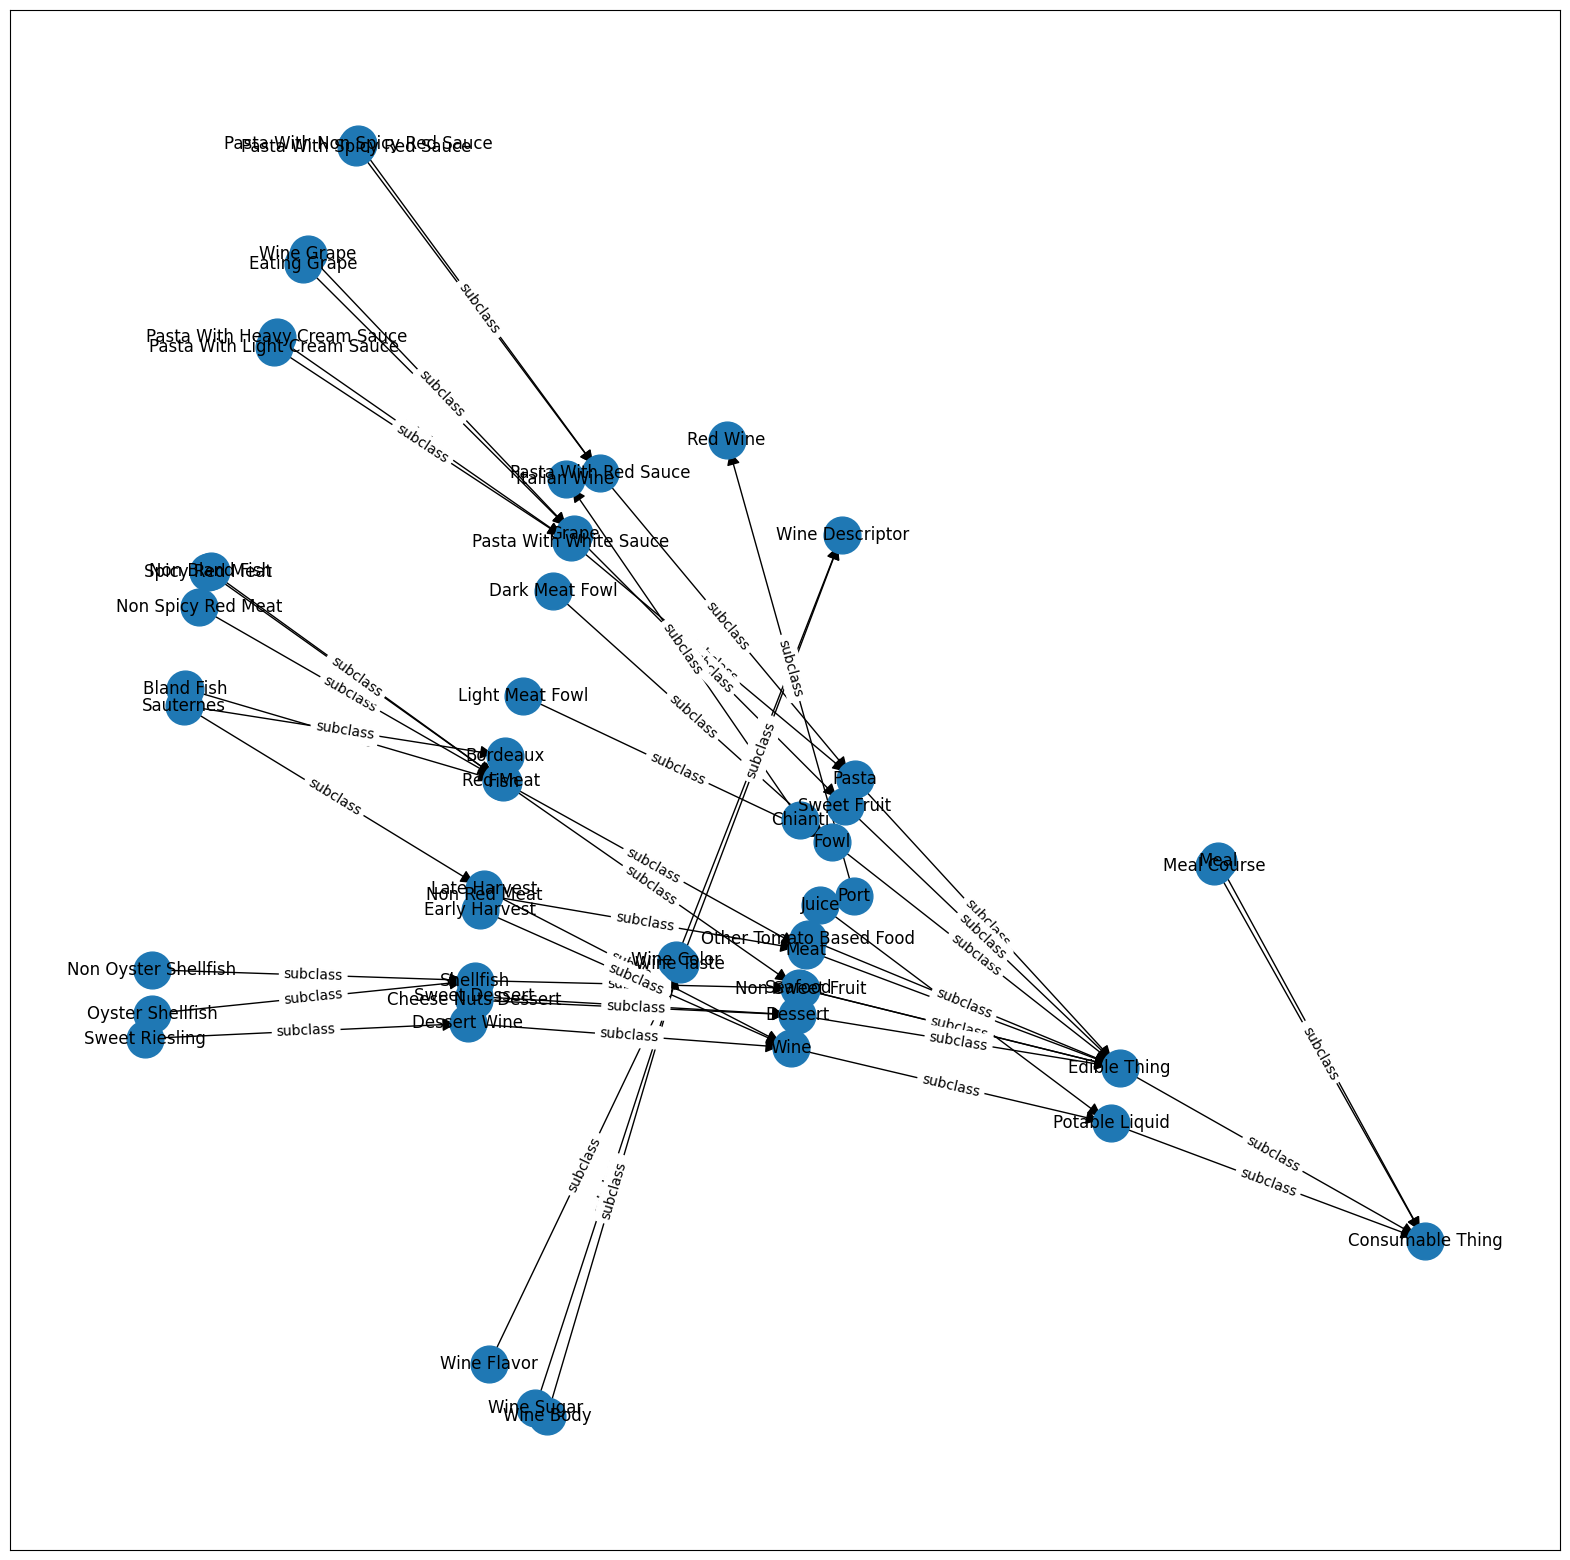

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
GX = nx.DiGraph()

for e in ents:
    GX.add_node(e, label=e)

for r in relations:
    GX.add_edge(r['source'], r['target'], label=r['rel'])

def plot_graph(G):
    plt.figure(figsize=(20,20))

    # Define node positions using a layout
    pos = nx.kamada_kawai_layout(G)

    # Draw the nodes with labels
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=12)

    # Draw the edges with labels
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'label'))

    # Display the graph
    plt.show()

plot_graph(GX)

Для выделения части дерева в виде списка, реализуем следующую функцию: 

In [20]:
def gen_tree(x):
    sub = [ gen_tree(r['source']) for r in relations if r['target']==x]
    if len(sub)==0:
        return x
    else:
        return { x : sub }
    
gen_tree("Consumable Thing")
        

{'Consumable Thing': [{'Edible Thing': [{'Meat': [{'Red Meat': ['Spicy Red Meat',
        'Non Spicy Red Meat']},
      'Non Red Meat']},
    'Non Sweet Fruit',
    'Other Tomato Based Food',
    {'Pasta': [{'Pasta With Red Sauce': ['Pasta With Spicy Red Sauce',
        'Pasta With Non Spicy Red Sauce']},
      {'Pasta With White Sauce': ['Pasta With Light Cream Sauce',
        'Pasta With Heavy Cream Sauce']}]},
    {'Sweet Fruit': [{'Grape': ['Wine Grape', 'Eating Grape']}]},
    {'Fowl': ['Light Meat Fowl', 'Dark Meat Fowl']},
    {'Seafood': [{'Fish': ['Bland Fish', 'Non Bland Fish']},
      {'Shellfish': ['Non Oyster Shellfish', 'Oyster Shellfish']}]},
    {'Dessert': ['Cheese Nuts Dessert', 'Sweet Dessert']}]},
  {'Potable Liquid': [{'Wine': [{'Dessert Wine': ['Sweet Riesling']},
      {'Late Harvest': ['Sauternes']},
      'Early Harvest']},
    'Juice']},
  'Meal',
  'Meal Course']}

In [21]:
def explore(x):
    anc = [ r['source'] for r in relations if r['target']==x]
    desc = [r['target'] for r in relations if r['source']==x]
    return anc, desc

explore("Wine")


(['Dessert Wine', 'Late Harvest', 'Early Harvest'], ['Potable Liquid'])

Очевидно, что не все нужные нам отношения присутствуют в этом дереве. Поэтому необходимо научиться использовать возможности логического вывода OWL+RDF для получение полной картины. 

In [23]:
from owlrl import CombinedClosure, DeductiveClosure, OWLRL_Extension
#DeductiveClosure(OWLRL_Extension).expand(G)
print(len(G))
CombinedClosure.RDFS_OWLRL_Semantics(G,None,None).closure()
print(len(G))

2709
21653


К онтологиям можно также делать запросы на языке SPARQL:

In [24]:
q = """
SELECT ?p ?f ?w
WHERE {
    ?p rdfs:subClassOf :MealCourse .
    ?p rdfs:subClassOf [ owl:onProperty :hasFood ; owl:allValuesFrom ?f ] .
    ?p rdfs:subClassOf [ owl:onProperty :hasDrink ; owl:allValuesFrom ?w ] .
}
"""

for p,f,w in G.query(q):
    if isinstance(p,URIRef) and isinstance(f,URIRef) and isinstance(w,URIRef):
        print(p,f,w)